In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.filterwarnings("ignore")

## 🎯 Problem Statement

Pada dataset *Insurance*, tujuan dari pemodelan ini adalah untuk **memprediksi total biaya tagihan asuransi (charges)** yang harus dibayar oleh seseorang berdasarkan beberapa karakteristik individu.

### Variabel Target
- **charges** → Total biaya asuransi (yang ingin diprediksi)

### Variabel Fitur (Independen)
- **age** → Usia pemegang asuransi  
- **sex** → Jenis kelamin  
- **bmi** → Body Mass Index (indeks massa tubuh)  
- **children** → Jumlah anak yang ditanggung  
- **smoker** → Status perokok (ya/tidak)  
- **region** → Wilayah tempat tinggal  

### Jenis Permasalahan
Masalah ini termasuk ke dalam **Supervised Learning** dengan tipe **Regression**, karena target yang diprediksi berupa nilai numerik kontinu.


In [2]:
df = pd.read_csv("dataset/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
df.duplicated().sum()

np.int64(1)

In [5]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


## 📊 Ringkasan Hasil Exploratory Data Analysis (EDA) (Hingga Describe)

### 1. Kondisi Data
- Dataset tidak memiliki **missing value**.
- Ditemukan **1 data duplikat**, dan sudah dihapus.
- Setelah pembersihan, total data berjumlah **1337 baris**.

---

### 2. Statistik Dasar Variabel Numerik

#### 👤 Usia (age)
- Rata-rata usia: **39 tahun**
- Standar deviasi: **14**
- Usia termuda: **18 tahun**
- Usia tertua: **64 tahun**
- 25% responden berusia di bawah **27 tahun**
- 50% (median) berusia di bawah **39 tahun**
- 75% berusia di bawah **51 tahun**

➡ Artinya, mayoritas peserta berada pada rentang usia dewasa muda hingga paruh baya.

---

#### ⚖️ Body Mass Index (BMI)
- Rata-rata BMI: **30**
- Standar deviasi: **6.1**
- BMI terendah: **15.9**
- BMI tertinggi: **53.1**
- 25% data di bawah **26.2**
- 50% (median): **30.4**
- 75% di bawah **34.7**

➡ Nilai rata-rata BMI berada pada kategori **overweight**, menunjukkan bahwa sebagian besar peserta memiliki berat badan di atas normal.

---

#### 👶 Jumlah Anak (children)
- Minimum: **0 anak**
- Maksimum: **5 anak**

➡ Mayoritas peserta memiliki jumlah anak yang relatif sedikit.

---

#### 💰 Biaya Asuransi (charges)
- Rata-rata biaya: **13.279**
- Standar deviasi: **12.110**
- Biaya terendah: **1.121**
- Biaya tertinggi: **63.770**
- 25% biaya di bawah **4.746**
- 50% (median): **9.386**
- 75% di bawah **16.657**

➡ Rentang biaya sangat lebar, menandakan adanya perbedaan besar antar individu, kemungkinan dipengaruhi oleh faktor seperti **status perokok, BMI, dan usia**.

---

### 3. Insight Awal
- Tidak ada masalah data kosong.
- Biaya asuransi memiliki variasi yang sangat besar.
- Usia dan BMI berada pada rentang yang cukup luas, sehingga berpotensi menjadi fitur penting dalam model.


Text(0.5, 1.0, 'Distribution Charges')

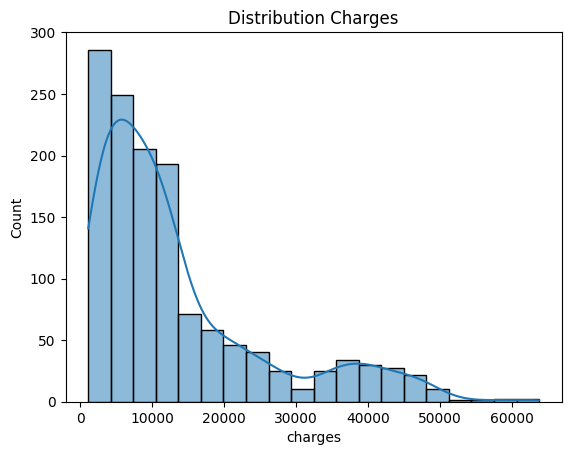

In [23]:
sns.histplot(data=df, bins=20, x='charges', kde=True)
plt.title("Distribution Charges")

# 📊 Analisis Distribusi Variabel: `charges`

Berdasarkan visualisasi histogram dan kurva *Kernel Density Estimate* (KDE) pada kolom target, berikut adalah ringkasan karakteristik datanya:

---

### 📈 1. Pola Distribusi (*Shape*)
Secara teknis, data ini menunjukkan pola **Right-Skewed** (Menjulur ke Kanan).
* 🧲 **Konsentrasi:** Mayoritas data "tertarik" ke sisi kiri (nilai rendah).
* 📏 **Ekor:** Memiliki ekor panjang ke arah kanan, yang menandakan adanya nilai tinggi namun jumlahnya sedikit.

### 📍 2. Analisis Tren Frekuensi
* **[0 - 10.000] — Dominasi Utama:** Rentang ini memiliki jumlah data terbanyak (puncak tertinggi). Ini adalah kelompok biaya yang paling umum terjadi.
* **[10.000 - 30.000] — Penurunan Drastis:** Terjadi penurunan jumlah frekuensi secara signifikan seiring meningkatnya nilai biaya.
* **[35.000 - 45.000] — Puncak Sekunder (Bimodal):** Terlihat adanya "gelombang kecil" atau kenaikan frekuensi kembali. Hal ini mengindikasikan adanya **kelompok khusus** (misal: kondisi medis tertentu atau gaya hidup tertentu) yang memiliki biaya lebih tinggi secara konsisten.

### ⚠️ 3. Nilai Ekstrem (Outliers)
* 📉 Di angka **60.000 ke atas**, distribusi data berada pada titik terendah.
* Nilai-nilai ini dianggap sebagai *outliers* atau pencilan yang bisa mempengaruhi nilai rata-rata (*mean*) secara keseluruhan.

### 💡 4. Kesimpulan Statistik
* ⚖️ Karena distribusinya tidak simetris, nilai **Median** akan lebih representatif untuk menggambarkan pusat data dibandingkan **Mean**.
* 🔍 Disarankan untuk melakukan analisis lebih lanjut (seperti *box plot*) untuk mengonfirmasi jumlah pasti pencilan pada sisi kanan.

---

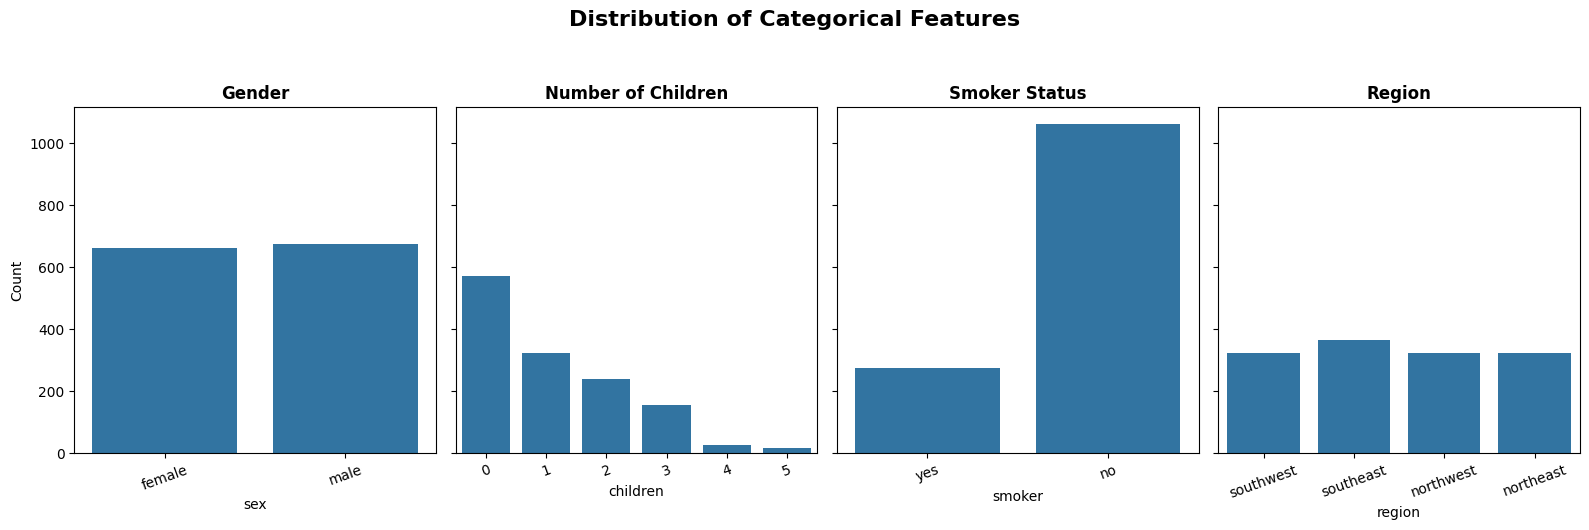

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 5), sharey=True)
axs = axs.ravel()
df.columns
cols = ['sex', 'children', 'smoker', 'region']
titles = ['Gender', 'Number of Children', 'Smoker Status', 'Region']

for i, col in enumerate(cols):
    sns.countplot(
        data=df, 
        x=col,
        ax=axs[i]
    )

    axs[i].set_title(titles[i], fontsize=12, fontweight='bold')
    axs[i].set_xlabel(col, fontsize=10)
    axs[i].set_ylabel('Count' if i == 0 else '')
    axs[i].tick_params(axis='x', rotation=20)

plt.suptitle(
    "Distribution of Categorical Features",
    fontsize=16,
    fontweight='bold',
    y=1.05
)

plt.tight_layout()
plt.show()

# 📊 Analisis Distribusi Fitur Kategorikal

Berdasarkan visualisasi *count plot* untuk variabel kategorikal, berikut adalah temuan kuncinya:

### 🚻 1. Gender (Jenis Kelamin)
* **Karakteristik:** Distribusi antara `female` dan `male` terlihat sangat seimbang (*nearly balanced*).
* **Detail:** Meskipun hampir mirip, jumlah kategori `male` sedikit lebih tinggi dibandingkan `female`, namun perbedaannya tidak signifikan.

### 👨‍👩‍👧‍👦 2. Number of Children (Jumlah Anak)
* **Karakteristik:** Distribusi data menunjukkan tren **menurun secara konsisten** (deksending).
* **Detail:** Mayoritas individu dalam dataset tidak memiliki anak (kategori `0`) dengan frekuensi mendekati 600. Jumlah ini terus berkurang secara bertahap hingga kategori `5` anak yang memiliki jumlah paling sedikit.

### 🚬 3. Smoker Status (Status Perokok)
* **Karakteristik:** Terdapat ketimpangan data (*imbalance data*) yang cukup mencolok.
* **Detail:** * Mayoritas besar responden adalah **Non-Smoker** (`no`) dengan jumlah di atas 1000.
    * Kelompok **Smoker** (`yes`) jauh lebih kecil, berada di kisaran angka 300-an. Hal ini menunjukkan populasi perokok dalam dataset ini cukup minoritas.

### 🗺️ 4. Region (Wilayah)
* **Karakteristik:** Distribusi geografis cenderung merata di keempat wilayah.
* **Detail:** Wilayah `southwest`, `northwest`, dan `northeast` memiliki jumlah yang hampir identik. Namun, wilayah **southeast** terlihat sedikit lebih unggul (memiliki jumlah data paling banyak) dibandingkan wilayah lainnya.

---

In [9]:
def charges_dist_by_category(col):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
    axs = axs.ravel()

    sns.histplot(data=df, x='charges', kde=True, hue=col, ax=axs[0])
    sns.boxenplot(data=df, x='charges', y=col, orient='h', ax=axs[1])

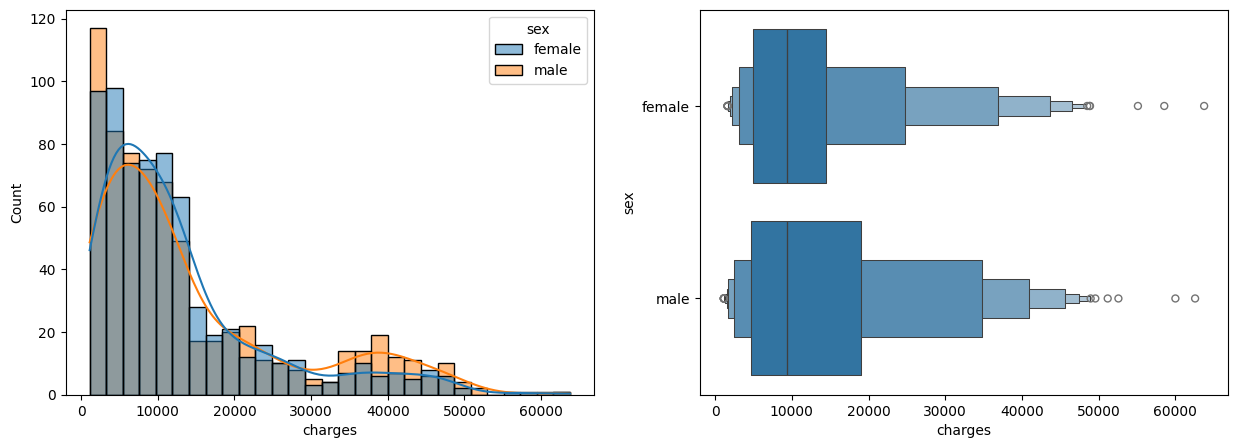

In [10]:
charges_dist_by_category('sex')

# 🚻 Analisis Hubungan Jenis Kelamin (`sex`) terhadap Biaya (`charges`)

Berdasarkan perbandingan distribusi antara `female` dan `male`, terdapat beberapa pola menarik yang dapat disimpulkan:

### 📉 1. Dominasi pada Rentang Biaya Rendah (0 - 30.000)
* **Temuan:** Pada rentang biaya rendah hingga menengah (di bawah 30.000), jumlah **female** cenderung lebih padat dibandingkan male.
* **Detail:** Grafik histogram menunjukkan batang biru (female) seringkali lebih tinggi pada bin awal, mengindikasikan lebih banyak perempuan yang memiliki tanggungan biaya di kelas harga ini.

### 📈 2. Dominasi pada Rentang Biaya Tinggi (30.000 - 50.000)
* **Temuan:** Pada rentang biaya tinggi (30.000 ke atas), jumlah **male** cenderung lebih unggul.
* **Detail:** Terlihat adanya "benjolan" kedua (puncak sekunder) pada kurva oranye (male) di area 40.000-an. Hal ini diperkuat oleh *boxenplot* di sisi kanan yang menunjukkan titik-titik pencilan (*outliers*) pada pria menjangkau angka yang lebih ekstrem (mendekati 60.000).

### ⚖️ 3. Ringkasan Statistik Visual
* **Median:** Meskipun secara kasat mata median keduanya terlihat mirip (garis tengah pada boxenplot), kelompok male memiliki sebaran (*spread*) data yang lebih lebar di sisi kanan (nilai tinggi).
* **Varians:** Biaya pada laki-laki memiliki variabilitas yang lebih tinggi, artinya kemungkinan seorang pria mendapatkan biaya sangat tinggi lebih besar dibandingkan perempuan dalam dataset ini.

---

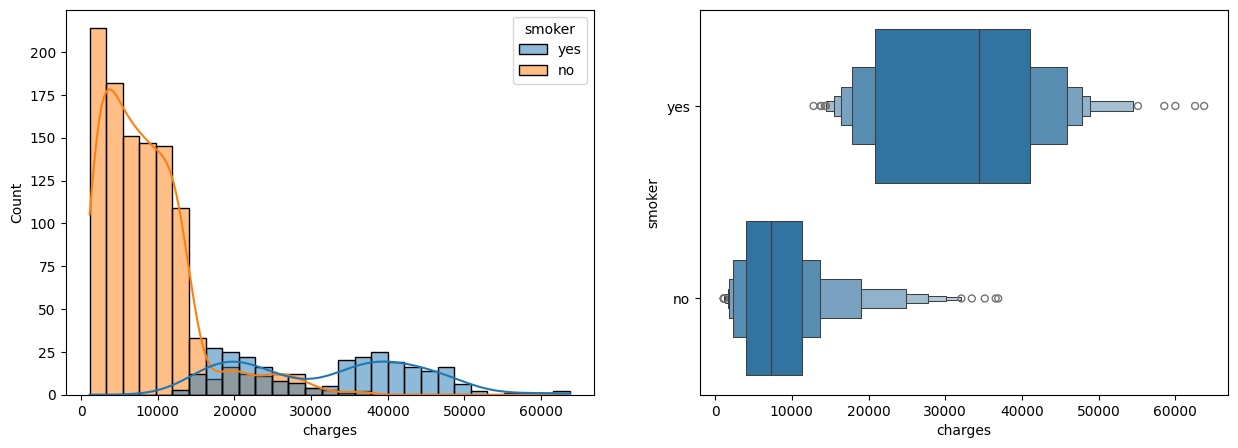

In [11]:
charges_dist_by_category('smoker')

# 🚬 Analisis Hubungan Status Perokok terhadap Biaya (`charges`)

Berdasarkan visualisasi data, perbedaan biaya antara perokok dan non-perokok sangat kontras dan signifikan. Berikut adalah poin analisisnya:

### 🚀 1. Perbandingan Biaya Minimum
* **Temuan:** Biaya terendah untuk kelompok **Smoker** (`yes`) dimulai dari kisaran **12.000 - 15.000**.
* **Perbandingan:** Sementara itu, bagi kelompok **Non-Smoker** (`no`), angka tersebut merupakan biaya menengah ke atas. Mayoritas non-perokok membayar jauh di bawah 10.000.

### 📈 2. Kepadatan pada Biaya Tinggi (High-Cost Area)
* **Temuan:** Kelompok perokok mendominasi area biaya **30.000 hingga 50.000+**. 
* **Detail:** Grafik histogram menunjukkan "gunung" kedua (area biru) yang sangat luas di sisi kanan. Hal ini menunjukkan bahwa tagihan medis tinggi bukan lagi kejadian langka (*outlier*) bagi perokok, melainkan sebuah kewajaran.

### ⚠️ 3. Analisis Outlier & Threshold
* **Temuan:** Biaya tertinggi dari non-perokok (yang dianggap sebagai titik-titik *outlier* pada *boxenplot*) baru menyentuh angka sekitar **35.000 - 40.000**.
* **Detail:** Menariknya, angka maksimal "luar biasa" bagi non-perokok ini justru menjadi angka "rata-rata" atau normal bagi kelompok perokok.

### 💡 4. Kesimpulan Strategis
Status perokok memiliki korelasi positif yang sangat kuat dengan peningkatan biaya asuransi. Secara visual, hampir tidak ada tumpang tindih (*overlap*) antara distribusi utama non-perokok dengan distribusi utama perokok di kelas biaya tinggi.

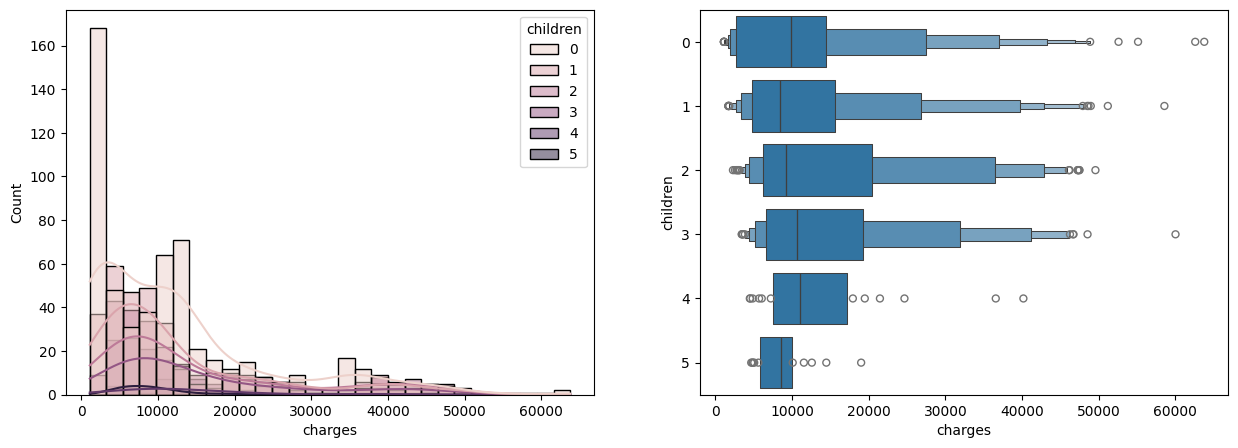

In [12]:
charges_dist_by_category('children')

# 👨‍👩‍👧‍👦 Analisis Hubungan Jumlah Anak (`children`) terhadap Biaya (`charges`)

Berdasarkan perbandingan distribusi pada berbagai jumlah anak, berikut adalah poin-poin analisis kritisnya:

### 1. Dominasi Sampel pada Kategori "0 Anak"
* **Temuan:** Grafik histogram menunjukkan puncak tertinggi (hampir 170 unit pada satu bin) berada pada kategori `0`.
* **Analisis:** Hal ini sejalan dengan analisis fitur kategorikal sebelumnya yang menunjukkan bahwa mayoritas responden memang tidak memiliki anak. Tingginya total akumulasi biaya di kategori ini lebih disebabkan oleh **jumlah sampel yang sangat besar**, bukan berarti tarif per individunya pasti lebih mahal.

### 2. Perbandingan Median (Pusat Data)
Jika kita melihat *boxenplot* di sisi kanan:
* **Stabilitas Median:** Garis median untuk kategori `0`, `1`, `2`, dan `3` anak sebenarnya terlihat berada di rentang yang hampir mirip (sekitar 8.000 - 10.000).
* **Tren Kategori 4 & 5:** Kategori dengan 4 dan 5 anak memiliki rentang kotak yang lebih sempit, yang menandakan variasi biayanya lebih kecil karena keterbatasan data sampel.

### 3. Validasi Kesimpulan
* **Kesimpulan Kamu:** Benar. Kita belum bisa menyimpulkan bahwa "semakin banyak anak = biaya lebih murah" hanya berdasarkan tinggi grafik histogram.
* **Alasan:** Perbedaan visual pada histogram sangat dipengaruhi oleh **ketimpangan jumlah data** (*imbalance data*). Untuk menarik kesimpulan yang adil, kita harus melihat nilai rata-rata (*mean*) atau median per kategori, bukan total frekuensinya.

### 💡 Insight Tambahan
Secara statistik, jumlah anak biasanya tidak memiliki pengaruh se-ekstrem status perokok terhadap `charges`. Fluktuasi yang kamu lihat pada jumlah anak 4 dan 5 kemungkinan besar adalah *noise* akibat ukuran sampel yang kecil (sedikit data).

<Axes: xlabel='children', ylabel='charges'>

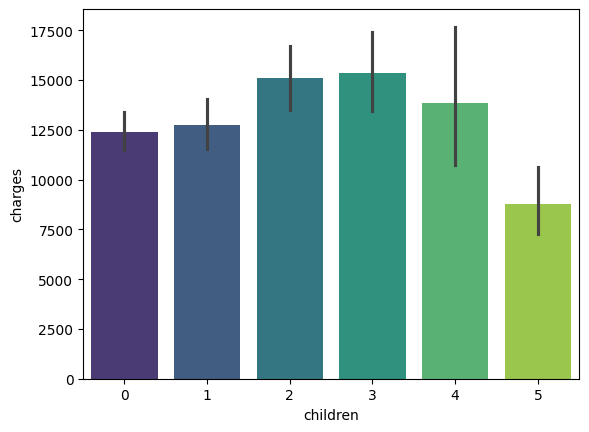

In [13]:
sns.barplot(data=df, x='children', y='charges', palette='viridis')

# 📊 Analisis Rata-rata Biaya berdasarkan Jumlah Anak (`children`)

Setelah beralih dari analisis frekuensi ke analisis nilai rata-rata (*mean*), terlihat pola distribusi yang lebih jelas mengenai bagaimana jumlah anak memengaruhi biaya asuransi:

### 🏆 1. Urutan Biaya Tertinggi
Berdasarkan grafik rata-rata, urutan biaya dari yang tertinggi ke terendah adalah:
1.  **3 Anak:** Memiliki rata-rata biaya tertinggi (mendekati 15.500).
2.  **2 Anak:** Mengikuti di posisi kedua (sekitar 15.000).
3.  **4 Anak:** Berada di posisi ketiga.
4.  **1 Anak:** Berada di posisi keempat.
5.  **0 Anak:** Berada di posisi kelima.
6.  **5 Anak:** Memiliki biaya terendah secara signifikan (di bawah 10.000).

### 📉 2. Kesenjangan Biaya pada 5 Anak
* **Temuan:** Terdapat selisih (*gap*) yang cukup besar antara kategori 5 anak dengan kategori lainnya.
* **Analisis:** Biaya asuransi untuk mereka yang memiliki 5 anak turun drastis hingga di bawah angka 9.000. Hal ini menarik karena secara umum biaya biasanya meningkat seiring bertambahnya tanggungan, namun data ini menunjukkan anomali pada kelompok tersebut.

### 🔍 3. Validasi Observasi Sebelumnya
* **Perbandingan:** Dulu saat melihat histogram, kelompok "0 anak" terlihat paling mahal karena jumlah datanya banyak. 
* **Fakta Baru:** Setelah dirata-ratakan, kelompok "0 anak" justru berada di posisi bawah (posisi ke-5), membuktikan bahwa kecurigaanmu sebelumnya benar: tingginya biaya di kelompok tersebut hanyalah efek dari besarnya jumlah sampel.

### 💡 Kesimpulan Akhir
Faktor jumlah anak memang memengaruhi biaya, dengan titik puncak beban finansial rata-rata berada pada keluarga dengan **2 hingga 3 anak**. Kelompok dengan 5 anak merupakan kelompok yang paling unik karena memiliki biaya rata-rata paling rendah di seluruh dataset.

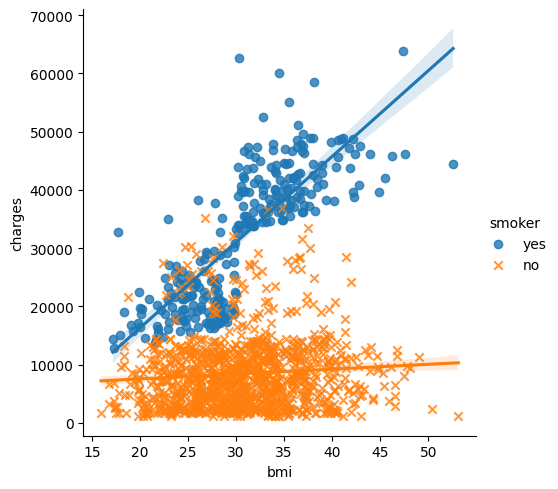

In [14]:
sns.lmplot(data=df, x="bmi", y="charges", hue="smoker", height=5, markers=['o', 'x'])

# 📉 Analisis Interaksi BMI, Status Merokok, dan Biaya Asuransi

Berdasarkan grafik regresi linear (`lmplot`) di atas, kita dapat membedah hubungan variabel-variabel tersebut sebagai berikut:

### 1. 🚬 Kelompok Perokok (Garis Biru & Marker 'o')
* **Kenaikan Drastis:** Terdapat korelasi positif yang sangat kuat dan curam antara BMI dan Charges.
* **Analisis:** Pada perokok, setiap kenaikan satu poin BMI berdampak pada lonjakan biaya yang signifikan. Titik-titik data menunjukkan bahwa perokok dengan BMI di atas 30 (obesitas) hampir seluruhnya memiliki biaya di atas **30.000 hingga 60.000+**.

### 🚭 2. Kelompok Non-Perokok (Garis Oranye & Marker 'x')
* **Kenaikan Landai:** Garis regresi cenderung horizontal/landai. 
* **Analisis:** Meskipun BMI meningkat, kenaikan biaya asuransi bagi mereka yang tidak merokok tidak terlalu agresif. Mayoritas tetap berada di bawah rentang **10.000 - 15.000**, bahkan bagi mereka yang memiliki BMI tinggi sekalipun.

### 💡 3. Kesimpulan Utama
* **Faktor Risiko Ganda:** BMI tinggi saja tidak secara otomatis membuat biaya asuransi melambung ekstrem. Namun, ketika **BMI tinggi bertemu dengan status perokok**, biaya tersebut naik secara eksponensial.
* **Titik Kritis:** Terlihat pemisahan (*gap*) yang sangat jelas antara kedua kelompok setelah melewati BMI 30. Ini menunjukkan bahwa risiko kesehatan bagi perokok dengan obesitas dinilai jauh lebih tinggi oleh penyedia asuransi.

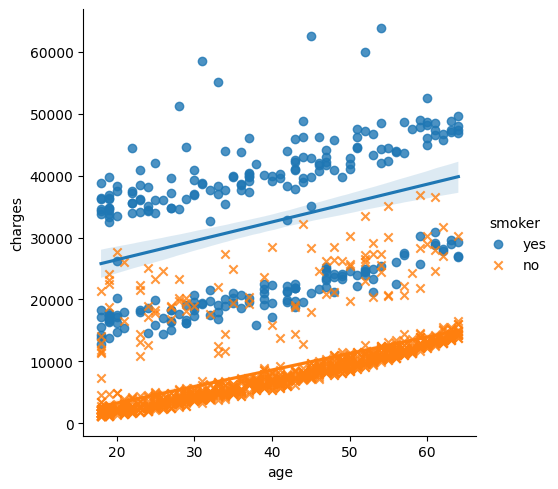

In [15]:
sns.lmplot(data=df, x="age", y="charges", hue="smoker", height=5, markers=['o', 'x'])

# 📈 Analisis Dampak Usia dan Status Perokok terhadap Biaya (`charges`)

Berdasarkan grafik Scatter Plot dengan garis regresi di atas, berikut adalah temuan kuncinya:

### 1. 🕒 Tren Kenaikan Berdasarkan Usia (Linier)
* **Temuan:** Kedua garis regresi (baik perokok maupun non-perokok) menunjukkan kemiringan (*slope*) yang mengarah ke atas seiring bertambahnya usia.
* **Analisis:** Ini membuktikan bahwa **usia memiliki korelasi positif** terhadap biaya asuransi. Semakin tua seseorang, risiko kesehatan meningkat sehingga biaya asuransi secara bertahap juga ikut naik.

### 🚬 2. Kesenjangan Biaya yang Masif (Smoker vs Non-Smoker)
* **Temuan:** Garis biru (perokok) berada jauh di atas garis oranye (non-perokok) dengan selisih biaya yang sangat lebar.
* **Analisis:** Status perokok menjadi faktor penentu (*key driver*) yang paling dominan. Meskipun usia sama, seorang perokok bisa membayar **2 hingga 3 kali lipat** lebih mahal dibandingkan non-perokok.

### 🔍 3. Pola Sebaran Data
* **Kelompok Non-Perokok:** Data terkumpul sangat rapi dan rapat di sepanjang garis regresi bawah. Ini menunjukkan kenaikan biaya bagi non-perokok sangat terprediksi berdasarkan usia.
* **Kelompok Perokok:** Data cenderung lebih tersebar (*high variance*). Terdapat dua kelompok perokok: satu kelompok dengan biaya tinggi (~20.000-30.000) dan satu kelompok lagi dengan biaya sangat ekstrem (~40.000-60.000). Hal ini kemungkinan besar dipengaruhi oleh faktor interaksi lain seperti BMI tinggi.

### 💡 Kesimpulan Akhir
Usia menyebabkan kenaikan biaya secara bertahap bagi semua orang, namun **status merokok memberikan beban biaya tambahan yang sangat besar** sejak awal masa dewasa (usia 18) hingga masa tua.

In [16]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True


<Axes: >

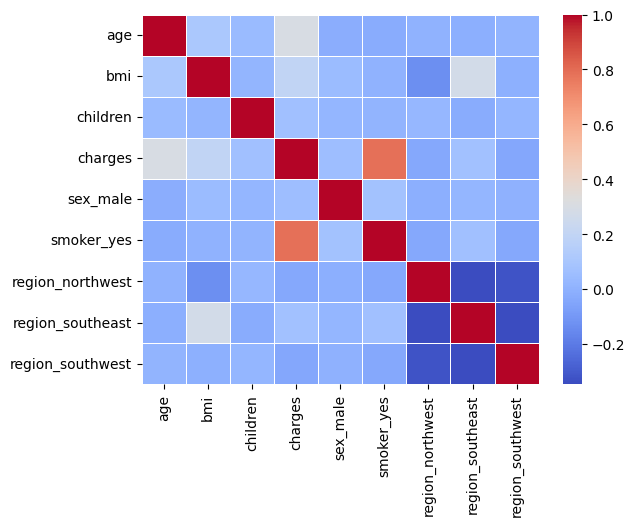

In [17]:
sns.heatmap(df_dummies.corr(), cmap='coolwarm', annot=False, linewidths=0.5)

In [18]:
x = df_dummies.drop('charges', axis=1)
y = df['charges']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

In [21]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

rf.fit(x_train_poly, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [22]:
y_pred = rf.predict(x_test_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE: ", rmse)
print("r2: ", r2)
print("MAE: ", mae)

RMSE:  4767.725909889007
r2:  0.8762968151802444
MAE:  2657.480258495336


### Hasil Evaluasi Model Prediksi

Berdasarkan hasil pengujian model, berikut adalah skor performa beserta interpretasinya:

* **RMSE:** `4767.72` — Artinya, secara rata-rata prediksi model melenceng sekitar $\pm$ 4.7 ribu unit dari nilai aslinya.
* **R²:** `0.876` — Artinya, 87.6% variasi data target dapat dijelaskan oleh model.
* **MAE:** `2657` — Artinya, selisih prediksi meleset sekitar $\pm$ 2.6 ribu unit.